# Gradient Boosted Decision Tree (GBDT) for Packaging Application
>**Research Project** : Part of < Privacy-Protected Compononet Obsolescence Detection via HE-GBDT > source code <br />
**Author** : Ha Eun David Kang (haeun@mit.edu), MIT MechE PhD Candidate <br />
**Data Source** : [Kaggle - Industrial Component Degradation](https://www.kaggle.com/inIT-OWL/one-year-industrial-component-degradation)

In [1]:
import glob
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance

from collections import OrderedDict
from tqdm import tqdm
from IPython.display import Image

!pip install tsfresh | grep -v 'Requirement already satisfied'
#!pip install statsmodels == 0.12.1
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

## 1. Data engineering

### 1.1. Data import

In [2]:
# File import
all_filenames = glob.glob('../dataset/*.csv')
print('Imported a total of {} files containing time series data from a vacuum-packaging machine operationa.'.format(len(all_filenames)))

# Merge 519 files into one dataframe
def prepare_files(x):
    
    acc = pd.DataFrame(columns = ['timestamp', 'pCut::Motor_Torque',
       'pCut::CTRL_Position_controller::Lag_error',
       'pCut::CTRL_Position_controller::Actual_position',
       'pCut::CTRL_Position_controller::Actual_speed',
       'pSvolFilm::CTRL_Position_controller::Actual_position',
       'pSvolFilm::CTRL_Position_controller::Actual_speed',
       'pSvolFilm::CTRL_Position_controller::Lag_error',
       'pSpintor::VAX_speed',
        'year', 'month', 'day', 'mode','id'])
    
    for i in range(len(x)):
        f = pd.read_csv(x[i])
        f['year'] = 2021 # can be any year
        f['month'] = int(x[i][11:13])
        f['day'] = int(x[i][14:16])
        f['mode'] = int(x[i][-5:-4])
        f['id'] = i+1
        acc = pd.concat([acc, f])
    
    acc.columns = ['time','motor_torque','cut_lag_error', 'cut_actual_position', 'cut_actual_speed', 'film_actual_position','film_actual_speed','film_lag_error','vax_speed','year','month','day','mode','id']
    
    return acc[['id','year', 'month','day','mode','time','motor_torque','cut_actual_position', 'cut_actual_speed', 'cut_lag_error', 'film_actual_position','film_actual_speed','film_lag_error','vax_speed']]

data = prepare_files(all_filenames)

# File length check
assert 519 * 2048 == len(data), 'import data shape is inconsistent'

Imported a total of 519 files containing time series data from a vacuum-packaging machine operationa.


In [3]:
df = data.copy() 

### 1.2. Define X and y

Feature Extraction: 100%|██████████████████████████████████████████████| 30/30 [01:32<00:00,  3.10s/it]


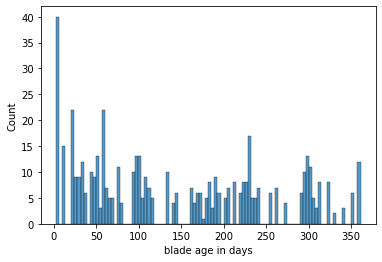

In [4]:
# subsample
subsample_num = 16
df = df[lambda x: x.index % subsample_num == 0].reset_index(drop=True)
df.index = np.tile(np.arange(128), 519)

# define y (blade age in days)
df['day'] = df[['month', 'day']].apply(lambda x: 28 if (x[0]==2) & (x[1]>28) else x[1], axis = 1)  # erroneous february data
dates = df[['year', 'month', 'day']].apply(lambda x: '-'.join(x.astype('str')), axis = 1)

y = (pd.to_datetime(dates.astype('str')) - pd.to_datetime('2021-01-01')).dt.days[::128].reset_index(drop=True)

fig, ax = plt.subplots()
ax = sns.histplot(y, bins = 100)
ax.set_xlabel('blade age in days')

# define X (time features & mode and vax_speed)
df['id'] = df.id.astype('int')
df['time'] = np.ravel(np.tile(np.arange(128), 519))

mode = df.iloc[lambda x: x.index%128==0]['mode'].reset_index(drop=True)
vax_speed = df.iloc[lambda x: x.index%128==0]['vax_speed'].reset_index(drop=True)

X = extract_features(df.drop(columns = ['year', 'month', 'day', 'mode', 'vax_speed']).astype(float), 
                     column_id='id', column_sort='time',
                     # default_fc_parameters=extraction_settings,
                     impute_function= impute,
                     n_jobs = 6).reset_index(drop=True)

X['mode'] = mode
X['vax_speed'] = vax_speed

assert sum(~(X.index == y.index)) == 0, 'X and y index or shape mismatch'

In [5]:
# null check
null_info = (X.isnull().sum(axis=0)!= 0)
print('{} columns with null values'.format(len(null_info[null_info].index)))

0 columns with null values


In [6]:
X.shape, y.shape

((519, 5511), (519,))

### 1.3. Preprocess data 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y,
                                        test_size = .2,
                                        shuffle = True,  # default = True
                                        random_state = 23
                                        )

print("Original # of features was {}.".format(X_train.shape[1]))

X_train_df = X_train.copy()
X_test_df = X_test.copy()

# Preprocessing 1. Variance Threshold
vt = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_train = vt.fit_transform(X_train)
X_test = vt.transform(X_test)

X_train_vt = X_train.copy()
X_test_vt = X_test.copy()

print("# of features after variance threshold drop is {}.".format(X_train.shape[1]))

# Preprocessing 2. SelectKBest
magic_depth = 7
K_best = 2**(magic_depth+1) - 1    ## 2^0 + ... + 2^n = 2^(n+1)-1
sel_k = SelectKBest(mutual_info_regression, k = K_best)
X_train = sel_k.fit_transform(X_train, y_train.astype(float))
X_test = sel_k.transform(X_test)

X_train_vt_sk = X_train.copy()
X_test_vt_sk = X_test.copy()

sel_k_scores = sel_k.scores_
sel_k_pvalues = sel_k.pvalues_

print("# of features after SelectKBest is {}.".format(X_train.shape[1]))

# Preprocessing 3. Scaling
max_val = pd.concat([pd.DataFrame(X_train).max(axis=0), pd.DataFrame(X_test).max(axis=0)], axis=1).max(axis=1).T
min_val = pd.concat([pd.DataFrame(X_train).min(axis=0), pd.DataFrame(X_test).min(axis=0)], axis=1).min(axis=1).T

X_train_set = (pd.DataFrame(X_train) - min_val)/(max_val - min_val)
X_test_set = (pd.DataFrame(X_test) - min_val)/(max_val - min_val)

assert np.abs(X_train_set.sum().sum() - 33800) < 1, 'unknown error. re-run.' # for random_state = 23

Original # of features was 5511.
# of features after variance threshold drop is 2897.
# of features after SelectKBest is 255.


<div class="alert alert-block alert-warning">
<b>Question 1. Isn't scaling unnecessary for tree-based estimators? </b> 
</div>

> Yes, it is true that while gradient-based estimators often assume standarized data with zero mean and unit variance, a notable exception are tree-based models. However, as been done also in [our first paper (Kang et. al, 2021)](https://www.sciencedirect.com/science/article/abs/pii/S0278612521001254), HE-based comparison we will use later requires two input points to be in (0, 1) interval.

<div class="alert alert-block alert-warning">
<b>Question 2. Shouldn't you not access train data when scaling? </b> 
</div>

> Yes, it is absolutely true that one must maintain test data as an unseen data set when preprocessing. So normally, you would fit scalers on train set then apply the transformation to test data set. However, we access test data to scale our test data down to (0, 1) interval to make sense of our HE algorithm. In practice, max_val and min_val would be set empirically with enough confidence that max(X_test) < max_val and min(X_test) > min_val.

In [14]:
y_train.values.mean() # 142.6144578313253

142.6144578313253

##  2. Supervised learning (GBDT)
### 2.1. Performance of 3 candidate models 

>Forcing each tree in the ensemble to consider only a subset of predictors is a technique often used to offset high variance induced by trees. Plotting the evolution of r2 score as we increase the number of trees in our ensemble for three different subpooling method gives us a direct insight into how many estimators & which subpooling method we would want to use.

In [15]:
X_train = X_train_set.copy()
X_test = X_test_set.copy()

In [16]:
X_train.shape, X_test.shape

((415, 255), (104, 255))

100%|██████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.28it/s]


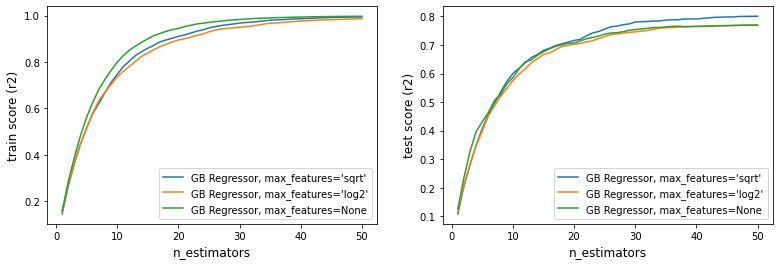

In [17]:
# Candidate regressors
ensemble_rgrs = [
    
    ("GB Regressor, max_features='sqrt'",
             GradientBoostingRegressor(loss = 'squared_error',
                                        learning_rate = 0.1,
                                        criterion = 'friedman_mse',
                                        max_depth = 6,
                                        random_state = 42,
                                        max_features = 'sqrt',
                                        warm_start = True
                                        )),
   
    ("GB Regressor, max_features='log2'", 
                GradientBoostingRegressor(loss = 'squared_error',
                                        learning_rate = 0.1,
                                        criterion = 'friedman_mse',
                                        max_depth = 6,
                                        random_state = 42,
                                        max_features = 'log2',
                                        warm_start = True
                                        )),
    
     ("GB Regressor, max_features=None", 
                GradientBoostingRegressor(loss = 'squared_error',
                                        learning_rate = 0.1,
                                        criterion = 'friedman_mse',
                                        max_depth = 6,
                                        random_state = 42,
                                        max_features = None,
                                        warm_start = True
                                        ))
]


r2 = {"GB Regressor, max_features='sqrt'": [],  "GB Regressor, max_features='log2'": [],  "GB Regressor, max_features=None": []}

error_rate = OrderedDict((label, []) for label, _ in ensemble_rgrs)

min_estimators = 1
max_estimators = 50

for label, rgr in ensemble_rgrs:
    for i in tqdm(range(min_estimators, max_estimators + 1)):
        rgr.set_params(n_estimators = i)
        rgr.fit(X_train, y_train)
        r2[label].append((i, rgr.score(X_train, y_train), rgr.score(X_test, y_test)))
        
    
# Plot train and test scores
fig, ax = plt.subplots(1,2, figsize = (13, 4))

for label, info in r2.items():
    i, train_r2, test_r2 = zip(*info)
    ax[0].plot(i, train_r2, label = label)
    ax[1].plot(i, test_r2, label = label)
    
ax[0].set_xlabel("n_estimators", fontsize = 12)
ax[0].set_ylabel("train score (r2)", fontsize = 12)
ax[0].legend(loc = 'lower right')

ax[1].set_xlabel("n_estimators", fontsize = 12)
ax[1].set_ylabel("test score (r2)", fontsize = 12)
ax[1].legend(loc = 'lower right')

<div class="alert alert-block alert-info">
<b>Key observation: Coexistence of interpolation and generalization</b> .</div>
    
> **Observation 1. High test performance via ensemble technique** <br>
The use of ensemble technique naturally allows model to avoid high variance and therefore generalize well on unseen data. <br>
    
> **Observation 2. High"er" test performance via feature subpooling** <br>
We can see that the adoption of subpooling methods (both 'sqrt' and 'log2') further decreases the model variance.<br>

> **Observation 3. Coexistence of interpolation and generalization, beyond the interpolation threshold** <br>
It seems it is still widely accepted in the machine learning community that the term 'overfitting' would imply decrease in test performance by default. However, it must be noted that this is no longer true since the publication of [<Understanding deep learning (still) requires rethinking generalization> by Zhang et. al (2017)](https://dl.acm.org/doi/abs/10.1145/3446776). The fact that our test score graph when flipped upside down does not show a typical U shaped bias-variance tradeoff is a manifestation that overfitting is not over-fitting at all. Such coexistence of perfect interpolation (train score = 1) and generlization has been shown in [another beautiful paper (Belkin 2019)](https://www.pnas.org/content/116/32/15849.short), where $N_{leaf}^{max}$ and $N_{tree}$ (max_leaf_nodes and n_estimators) represent the model complexity. In this spirit, the test graph we observe above is a graph drawn in the regime beyond interpolation threshold.

### 2.2. Best model report

In [18]:
# Test report
findmaxr2 = {"GB Regressor, max_features='sqrt'": [],  "GB Regressor, max_features='log2'": [],  "GB Regressor, max_features=None": []}

for label, info in r2.items():
    *_, test_r2 = zip(*info)
    findmaxr2[label].append(max(test_r2))
    
r2_max_test_val = max(findmaxr2.values())[0] # maximum test r2 value
label_num = list(findmaxr2.values()).index(r2_max_test_val) # corresponding label number (0, 1, 2)
label_name = list(findmaxr2.keys())[label_num]
r2_max_test_n_est = list(zip(*r2[label_name]))[2].index(r2_max_test_val)

print("best test r2 is {:.3f} at {} n_est.".format(r2_max_test_val, r2_max_test_n_est))

best test r2 is 0.801 at 49 n_est.


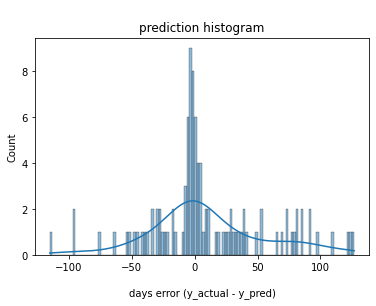


Best model is GradientBoostingRegressor(max_depth=6, max_features='sqrt', n_estimators=49,
                          random_state=42)

                  r2   under 30 days error  under 60 days error
test performance  0.8                0.596                0.788


In [19]:
# Best model report
best_max_feature = label_num
best_n_estimators = r2_max_test_n_est

gbr_pick = ensemble_rgrs[best_max_feature][1]
gbr_pick.set_params(n_estimators = best_n_estimators, warm_start = False, random_state = 42)

gbr_pick.fit(X_train, y_train)

fig, ax = plt.subplots()
error = y_test - gbr_pick.predict(X_test)
ax = sns.histplot(error, bins = 120, kde = True)
ax.set_xlabel('\ndays error (y_actual - y_pred)')
ax.set_title('\nprediction histogram')
plt.show()

print('\nBest model is {}\n'.format(gbr_pick))
print(pd.DataFrame({'r2 ': [np.round(gbr_pick.score(X_test, y_test), 3)], 'under 30 days error': [np.round(np.sum(np.abs(error)<=30)/len(error), 3)], 'under 60 days error' : [np.round(np.sum(np.abs(error)<=60)/len(error), 3)]}).T.rename(columns = {0:'test performance'}).T)

### 2.3. Inspection on the Best Model

<div class="alert alert-block alert-info">
<b>Caution: Tree-based models show high bias towards high cardinality features.</b> </div>

>Tree-based models are biased towards high cardinality features. In other words, if we inject a random feature into our dataset, our model would tend to consider the feature as one of the most 'important' ones by overfitting, assuming our model has enough capacity. Here, the importance is computed as the normalized total reduction of a certain criterion brought by the feature. In regression, it is the reduction in variance, and for classification it is aka Gini Importance or Mean Decrease in Impurity (MDI). To identify such misleading features, we conduct a permutation test.

Text(0.5, 0, 'Metric baseline minus metric from permutating the feature')

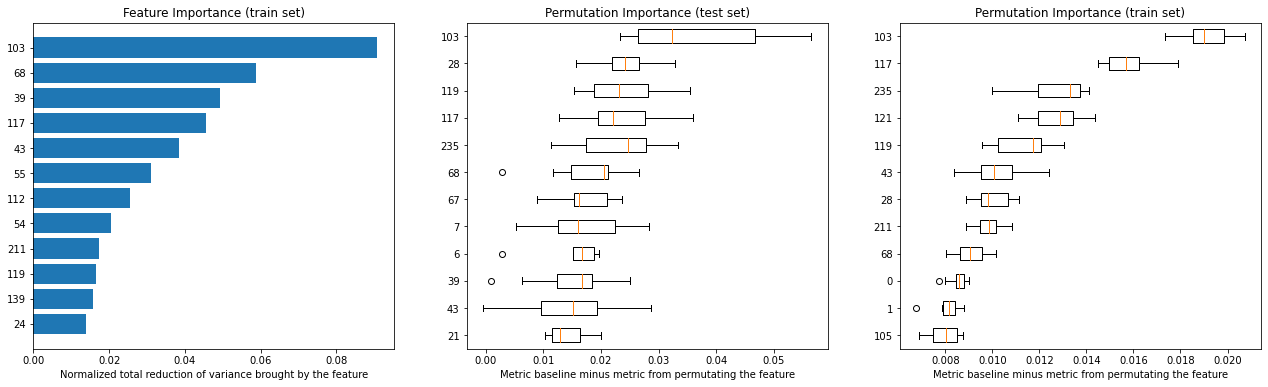

In [20]:
def extract_col_names_idx(mother, baby, baby_idx):
    res = []
    for i in baby_idx:
        res.append(np.where(np.sum(mother.T.values == baby.T[i], axis=1) == mother.shape[0])[0][0])
    return list(mother.columns[res])

def extract_col_names_overlap(mother, baby):
    res = []
    for i in range(baby.shape[1]): # 255
        res.append(np.where(np.sum(mother.T.values == baby.T[i], axis=1) == mother.shape[0])[0][0])
    return list(mother.columns[res])

fig, ax = plt.subplots(1,3, figsize = (22, 6))

# 1. Feature importance from model (train data)
top_ind_model = np.argsort(gbr_pick.feature_importances_)[-12:]
feature_names = extract_col_names_idx(X_train_df, X_train_vt_sk, top_ind_model)
ax[0].barh(np.arange(12)+0.5, gbr_pick.feature_importances_[top_ind_model])
ax[0].set_yticks(np.arange(12)+0.5)
ax[0].set_yticklabels(top_ind_model)
ax[0].set_title("Feature Importance (train set)")
ax[0].set_xlabel('Normalized total reduction of variance brought by the feature')

# 2. Permutation importance (test data)
perm_imp_test = permutation_importance(gbr_pick, X_test, y_test, n_repeats = 10, random_state = 22, n_jobs = -1) 
perm_sorted_idx_test = perm_imp_test.importances_mean.argsort()
ax[1].boxplot(perm_imp_test.importances[perm_sorted_idx_test][-12:].T, vert = False, labels = pd.DataFrame(X_test).columns[perm_sorted_idx_test][-12:])
ax[1].set_title("Permutation Importance (test set)")
ax[1].set_xlabel('Metric baseline minus metric from permutating the feature')

# 3. Permutation importance (train data)
perm_imp_train = permutation_importance(gbr_pick, X_train, y_train, n_repeats = 10, random_state = 22, n_jobs = -1)
perm_sorted_idx_train = perm_imp_train.importances_mean.argsort()
ax[2].boxplot(perm_imp_train.importances[perm_sorted_idx_train][-12:].T, vert = False, labels = pd.DataFrame(X_test).columns[perm_sorted_idx_train][-12:])
ax[2].set_title("Permutation Importance (train set)")
ax[2].set_xlabel('Metric baseline minus metric from permutating the feature')

> **Discussion** <br>
Permutation importance is computed as the decrease in model score when a feature column is randomly shuffled, so features with low permutation importance (close to 0) deserves skepticism. Note how feature 43 appears high up in rank in the first graph, but contains 0 in its interval in the second graph. This means our GBDT had enough capacity to use feature 43 to overfit train set. It appears higher in rank in the third graph, supporting our conjecture of overfitting.

> **Conclusion** <br>
We remove feature 43, 'cut_actual_position__sum_values', and continue.

### 2.4. Re-find the best model 

In [24]:
X_train = X_train.copy().drop(columns = 43)
X_test = X_test.copy().drop(columns = 43)

# Candidate regressors
ensemble_rgrs = [
    
    ("GB Regressor, max_features='sqrt'",
             GradientBoostingRegressor(loss = 'squared_error',
                                        learning_rate = 0.1,
                                        criterion = 'friedman_mse',
                                        max_depth = 6,
                                        random_state = 42,
                                        max_features = 'sqrt',
                                        warm_start = True
                                        )),
   
    ("GB Regressor, max_features='log2'", 
                GradientBoostingRegressor(loss = 'squared_error',
                                        learning_rate = 0.1,
                                        criterion = 'friedman_mse',
                                        max_depth = 6,
                                        random_state = 42,
                                        max_features = 'log2',
                                        warm_start = True
                                        )),
    
     ("GB Regressor, max_features=None", 
                GradientBoostingRegressor(loss = 'squared_error',
                                        learning_rate = 0.1,
                                        criterion = 'friedman_mse',
                                        max_depth = 6,
                                        random_state = 42,
                                        max_features = None,
                                        warm_start = True
                                        ))
]


r2 = {"GB Regressor, max_features='sqrt'": [],  "GB Regressor, max_features='log2'": [],  "GB Regressor, max_features=None": []}

error_rate = OrderedDict((label, []) for label, _ in ensemble_rgrs)

min_estimators = 1
max_estimators = 50

for label, rgr in ensemble_rgrs:
    for i in tqdm(range(min_estimators, max_estimators + 1)):
        rgr.set_params(n_estimators = i)
        rgr.fit(X_train, y_train)
        r2[label].append((i, rgr.score(X_train, y_train), rgr.score(X_test, y_test)))
        
# Test report
findmaxr2 = {"GB Regressor, max_features='sqrt'": [],  "GB Regressor, max_features='log2'": [],  "GB Regressor, max_features=None": []}

for label, info in r2.items():
    *_, test_r2 = zip(*info)
    findmaxr2[label].append(max(test_r2))
    
r2_max_test_val = max(findmaxr2.values())[0] # maximum test r2 value
label_num = list(findmaxr2.values()).index(r2_max_test_val) # corresponding label number (0, 1, 2)
label_name = list(findmaxr2.keys())[label_num]
r2_max_test_n_est = list(zip(*r2[label_name]))[2].index(r2_max_test_val)

print("best test r2 is {:.3f} at {} n_est.".format(r2_max_test_val, r2_max_test_n_est))

# Best model report
best_max_feature = label_num
best_n_estimators = r2_max_test_n_est

gbr_pick = ensemble_rgrs[best_max_feature][1]
gbr_pick.set_params(n_estimators = best_n_estimators, warm_start = False, random_state = 42)

gbr_pick.fit(X_train, y_train)

100%|██████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.60it/s]

best test r2 is 0.805 at 48 n_est.


GradientBoostingRegressor(max_depth=6, max_features='log2', n_estimators=48,
                          random_state=42)

## 3. Model compute sanity check

In [25]:
def validate_gbr(gbdt, y_train_mean, testx): # checking F(x) == avg + 0.1 * {f1(x) + f2(x) + ... + fn(x)} ( n trees )
    RHS = y_train_mean
    for i in range(len(gbdt.estimators_)):
        RHS += (0.1 * gbdt.estimators_[i][0].predict(testx))
    LHS = gbdt.predict(testx)
    return True if (RHS == LHS) else False

for m in range(len(X_test)):
    if validate_gbr(gbr_pick, y_train.values.mean(), X_test.iloc[m,:].values.reshape(1,-1)) == True:
        if (m == len(X_test)-1):
            print("Your GBDT is confirmed! F(x) is indeed avg + 0.1 * {f1(x) + f2(x) + ... + fn(x)}")
        continue
    print("Failed!")

Your GBDT is confirmed! F(x) is indeed avg + 0.1 * {f1(x) + f2(x) + ... + fn(x)}


## 4. Extract trees node info

> To implement our GBDT using Microsoft's SEAL HE library, we extract tuples of (feature, threshold) for splitting nodes and (values) for leaf nodes. To enable our SEAL code to work across trees with different shapes, we save (values) as (-2, values) for leaf nodes, and (-2, -2.0) for imaginary nodes under the leaf nodes.

In [26]:
floor_6 = np.array([6, 7, 9, 10, 13, 14, 16, 17, 21, 22, 24, 25, 28, 29, 31, 32, 37, 38, 40, 41, 44, 45, 47, 48, 52, 53, 55, 56, 59, 60, 62, 63])
floor_6 = np.append(floor_6, floor_6 + 63)

floor_5 = np.array([5, 8, 12, 15, 20, 23, 27, 30, 36, 39, 43, 46, 51, 54, 58, 61])
floor_5 = np.append(floor_5, floor_5 + 63)

floor_4 = np.array([4, 11, 19, 26, 35, 42, 50, 57])
floor_4 = np.append(floor_4, floor_4 + 63)

floor_3 = np.array([3, 18, 34, 49])
floor_3 = np.append(floor_3, floor_3 + 63)

floor_2 = np.array([2, 33])
floor_2 = np.append(floor_2, floor_2 + 63)

floor_1 = np.array([1, 64])
floor_0 = np.array([0])

floor_dic = {6: floor_6, 5: floor_5, 4: floor_4, 3: floor_3, 2: floor_2, 1: floor_1, 0: floor_0}

floor_012345 = np.array(list(floor_0) + list(floor_1) + list(floor_2) + list(floor_3) + list(floor_4) + list(floor_5))


def extract_reinforce_f_t_pairs(tree):
    res = []
    
    if tree.get_depth()!= 6:
        print("There exists a tree that its depth is not 6!")
    
    def floor_num(p):
        for j in floor_dic.keys():
            if p in floor_dic[j]:
                return j

    spy = 0
    
    for p in range(tree.tree_.node_count):
        
        if (spy in floor_012345) and (tree.tree_.children_left[p] != -1):
            res.append((tree.tree_.feature[p], tree.tree_.threshold[p]))
            spy += 1
    
        elif (spy in floor_012345) and (tree.tree_.children_left[p] == -1):
            
            res.append((-2, tree.tree_.value[p][0,0]))
            
            k = floor_num(spy)
            for q in range(1, 2**(7-k)-1):
                res.append((-2, -2.0))
            spy += 2**(7-k)-1
                
        elif (spy in floor_6) and (tree.tree_.children_left[p] == -1):
            res.append((-2, tree.tree_.value[p][0,0]))
            spy += 1
            
    return res     


final_trees_info = [extract_reinforce_f_t_pairs(tree[0]) for tree in gbr_pick.estimators_]

for i in range(len(final_trees_info)):
    if len(final_trees_info[i]) == 127:
        if i == len(final_trees_info)-1:
            print("Success! You can save your results.")
        continue
    print("There exists an error. Please recheck if reinforcement has done properly on {}th tree".format(i))

Success! You can save your results.


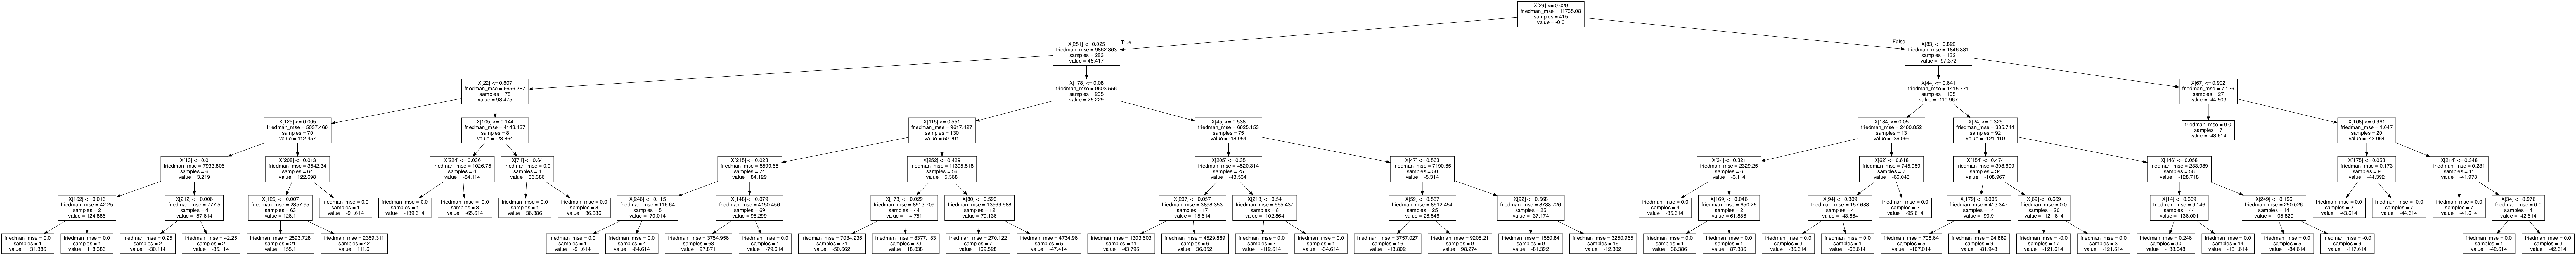

In [27]:
export_graphviz(gbr_pick.estimators_[0][0], out_file ='reproduce_tree1.dot')
!dot -Tpng 'reproduce_tree1.dot' -o 'reproduce_tree1.png'
Image('reproduce_tree1.png')

In [28]:
final_trees_info[0][:10] # indeed matches above tree!

[(29, 0.0294629093259573),
 (251, 0.025464065372943878),
 (22, 0.6067717671394348),
 (125, 0.00528718251734972),
 (13, 0.00039980268047656864),
 (162, 0.016039983835071325),
 (-2, 131.3855421686747),
 (-2, 118.3855421686747),
 (212, 0.0056420613545924425),
 (-2, -30.114457831325296)]

## 5. Save for HE code

In [77]:
# node info
pd.DataFrame(final_trees_info).to_csv('reproduce_final_ensemble_info.csv')

# train & test data
pd.DataFrame(y_train, columns = ['value']).to_csv('reproduce_y_train.csv')
pd.DataFrame(y_test, columns = ['value']).to_csv('reproduce_y_test.csv')
pd.DataFrame(X_train).to_csv('reproduce_X_train.csv')
pd.DataFrame(X_test).to_csv('reproduce_X_test.csv')

# y_preds
y_preds = {}
for i in range(len(gbr_pick.estimators_)):
    y_preds[i] = gbr_pick.estimators_[i][0].predict(X_test)

pd.DataFrame(y_preds).T.to_csv('reproduce_y_preds.csv')

# model
joblib.dump(gbr_pick , 'model_jlib')

# retrieve model and check
m_jlib = joblib.load('model_jlib')

In [57]:
y_train.mean()

142.6144578313253